In [57]:
import pandas as pd, numpy as np, os
from sklearn.metrics import f1_score, accuracy_score
from itertools import product
from scipy.stats import wilcoxon
from glob import glob
import matplotlib.pyplot as plt  
import seaborn as sns

In [4]:
# Increase font sizes  
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Read in the each of the target testing results and summarize those results

In [7]:
# Path to the directory containing CSV files
directory = "bias results"

# Columns to calculate F1 scores for
columns_to_compare = ['context_preds_normal', 'zero_shot_cot_preds_normal', 'context_preds_underspecify', 
                     'zero_shot_cot_preds_underspecify', 'context_preds_candidate_and_name', 
                     'zero_shot_cot_preds_candidate_and_name', 'context_preds_party', 
                     'zero_shot_cot_preds_party', 'context_preds_party_and_name', 
                     'zero_shot_cot_preds_party_and_name', 'context_preds_misspelling', 
                     'zero_shot_cot_preds_misspelling']

In [51]:
# Initialize a dictionary to store F1 scores
results = []

# Iterate over each CSV file in the directory
for filename in os.listdir(directory):
    if filename.startswith("target_testing_results") and filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        
        # Iterate over unique events
        unique_events = df['event'].unique()
        for event in unique_events:
            # Iterate over unique datasets
            unique_datasets = df['dataset'].unique()
            for dataset in unique_datasets:
                event_df = df[(df['event'] == event) & (df['dataset'] == dataset)]
                stance = event_df['stance']
                for column in columns_to_compare:
                    datum = {}
                    datum['model'] = filepath[36:-4]
                    predicted = event_df[column]
                    f1 = f1_score(stance, predicted, average='macro')
                    datum['event'] = event
                    datum['dataset'] = dataset
                    if 'zero_shot_cot_preds' in column:
                        datum['prompting_scheme']= 'zero_shot_cot'
                        datum['target_alteration'] = column.split('_',4)[-1]
                    else:
                        datum['prompting_scheme'] = 'context'
                        datum['target_alteration'] = column.split('_',2)[-1]
                    datum['f1_score'] = f1
                    results.append(datum)

results_df = pd.DataFrame(results)

## Are the F1 scores different between different target alterations?

In [52]:
# Group by 'target_alteration' and calculate mean and standard deviation of 'f1_score'
grouped_df = results_df.groupby('target_alteration')['f1_score'].agg(['mean', 'std'])

# Print the grouped DataFrame
print(grouped_df)

                        mean       std
target_alteration                     
candidate_and_name  0.362654  0.133102
misspelling         0.355871  0.126358
normal              0.357450  0.130865
party               0.345068  0.117772
party_and_name      0.362981  0.123140
underspecify        0.342855  0.126004


In [53]:
# Group by 'target_alteration' and 'prompting_scheme', and calculate mean and standard deviation of 'f1_score'
grouped_df = results_df.groupby(['target_alteration', 'prompting_scheme'])['f1_score'].agg(['mean', 'std'])

# Print the grouped DataFrame
print(grouped_df)

                                         mean       std
target_alteration  prompting_scheme                    
candidate_and_name context           0.401359  0.133740
                   zero_shot_cot     0.323948  0.122404
misspelling        context           0.389194  0.126768
                   zero_shot_cot     0.322549  0.118515
normal             context           0.389136  0.135775
                   zero_shot_cot     0.325765  0.119387
party              context           0.372435  0.122589
                   zero_shot_cot     0.317701  0.107602
party_and_name     context           0.399416  0.128514
                   zero_shot_cot     0.326546  0.107350
underspecify       context           0.369993  0.128134
                   zero_shot_cot     0.315716  0.119525


In [54]:
grouped_df = results_df.groupby(['target_alteration', 'event'])['f1_score'].agg(['mean', 'std'])

# Print the grouped DataFrame
print(grouped_df)

                                        mean       std
target_alteration  event                              
candidate_and_name Donald Trump     0.338253  0.089199
                   Hillary Clinton  0.378921  0.154589
misspelling        Donald Trump     0.333655  0.094795
                   Hillary Clinton  0.370682  0.142796
normal             Donald Trump     0.329253  0.102034
                   Hillary Clinton  0.376249  0.145122
party              Donald Trump     0.320334  0.078109
                   Hillary Clinton  0.361557  0.136486
party_and_name     Donald Trump     0.334895  0.080478
                   Hillary Clinton  0.381705  0.142674
underspecify       Donald Trump     0.318232  0.093591
                   Hillary Clinton  0.359270  0.142343


In [55]:
alteration_df = results_df.pivot_table(index=['model','dataset', 'event', 'prompting_scheme'], columns='target_alteration', values='f1_score')

In [58]:
alteration_df.head()

target_alteration                                              candidate_and_name  \
model               dataset  event           prompting_scheme                       
Llama-2-13b-chat-hf basil    Donald Trump    context                     0.286315   
                                             zero_shot_cot               0.231030   
                             Hillary Clinton context                     0.155556   
                                             zero_shot_cot               0.222222   
                    election Donald Trump    context                     0.430801   

target_alteration                                              misspelling  \
model               dataset  event           prompting_scheme                
Llama-2-13b-chat-hf basil    Donald Trump    context              0.167178   
                                             zero_shot_cot        0.205175   
                             Hillary Clinton context              0.223443   
                                             zero_shot_cot        0.172043   
                    election Donald Trump    context              0.429467   

target_alteration                                                normal  \
model               dataset  event           prompting_scheme             
Llama-2-13b-chat-hf basil    Donald Trump    context           0.143301   
                                             zero_shot_cot     0.166170   
                             Hillary Clinton context           0.137931   
                                             zero_shot_cot     0.321693   
                    election Donald Trump    context           0.411886   

target_alteration                                                 party  \
model               dataset  event           prompting_scheme             
Llama-2-13b-chat-hf basil    Donald Trump    context           0.298391   
                                             zero_shot_cot     0.245758   
                             Hillary Clinton context           0.202020   
                                             zero_shot_cot     0.288889   
                    election Donald Trump    context           0.393062   

target_alteration                                              party_and_name  \
model               dataset  event           prompting_scheme                   
Llama-2-13b-chat-hf basil    Donald Trump    context                 0.288495   
                                             zero_shot_cot           0.231356   
                             Hillary Clinton context                 0.196078   
                                             zero_shot_cot           0.228352   
                    election Donald Trump    context                 0.425485   

target_alteration                                              underspecify  
model               dataset  event           prompting_scheme                
Llama-2-13b-chat-hf basil    Donald Trump    context               0.134732  
                                             zero_shot_cot         0.198507  
                             Hillary Clinton context               0.119048  
                                             zero_shot_cot         0.284722  
                    election Donald Trump    context               0.436933

In [65]:
p_values_df = pd.DataFrame(index=alteration_df.columns, columns=alteration_df.columns)

# Perform Wilcoxon signed-rank test for each pair of columns
for column1 in alteration_df.columns:
    for column2 in alteration_df.columns:
        if column1 != column2:
            statistic, p_value = wilcoxon(alteration_df[column1], alteration_df[column2])
            p_values_df.loc[column1, column2] = p_value
            if p_value <= 0.05: #Print statistically different target alteration pairs
                print(f"Comparison between {column1} and {column2}:")
                print(f"  Statistic: {statistic}")
                print(f"  p-value: {p_value}\n")

p_values_df = p_values_df.fillna(0.0)

Comparison between candidate_and_name and party:
  Statistic: 533.0
  p-value: 3.2940430344713085e-05

Comparison between candidate_and_name and underspecify:
  Statistic: 836.0
  p-value: 0.026338869517132203

Comparison between misspelling and party:
  Statistic: 655.0
  p-value: 0.0009553098362273228

Comparison between misspelling and underspecify:
  Statistic: 782.0
  p-value: 0.010957801293342966

Comparison between normal and party:
  Statistic: 603.0
  p-value: 0.00030119150162346024

Comparison between normal and underspecify:
  Statistic: 808.0
  p-value: 0.010997654134190241

Comparison between party and candidate_and_name:
  Statistic: 533.0
  p-value: 3.2940430344713085e-05

Comparison between party and misspelling:
  Statistic: 655.0
  p-value: 0.0009553098362273228

Comparison between party and normal:
  Statistic: 603.0
  p-value: 0.00030119150162346024

Comparison between party and party_and_name:
  Statistic: 587.0
  p-value: 0.00012500062189744137

Comparison between

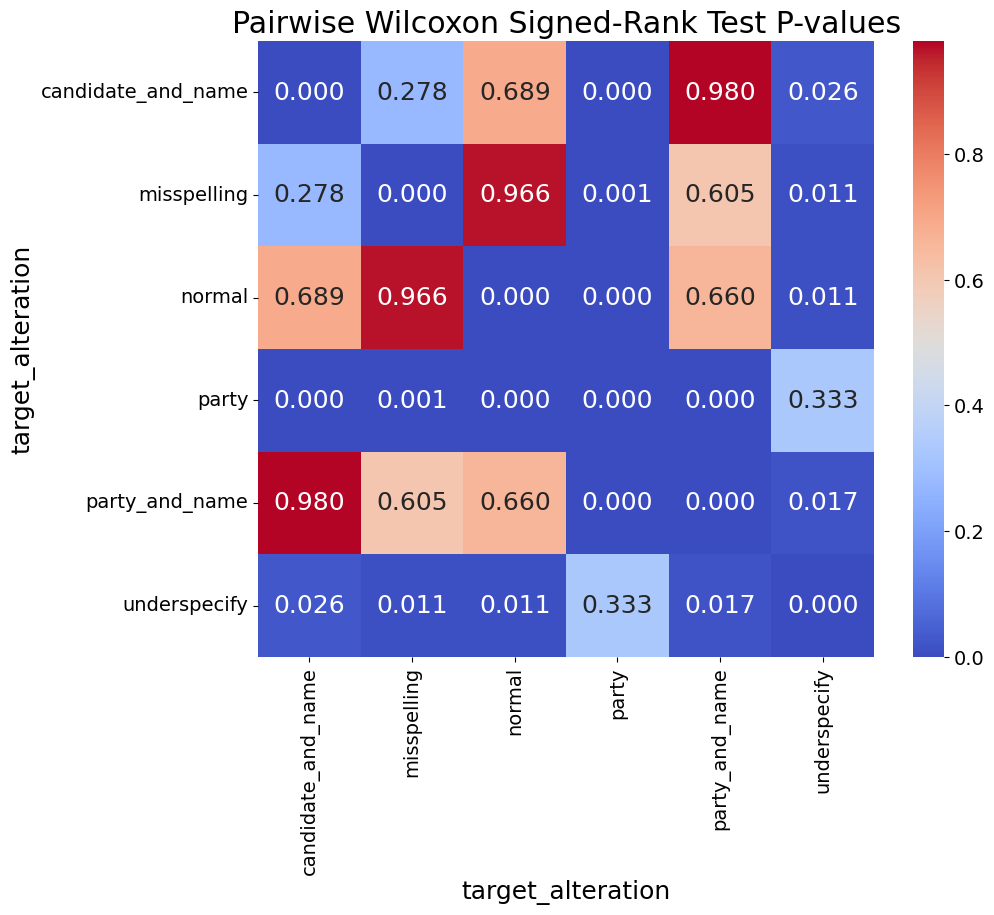

In [72]:
plt.figure(figsize=(10, 8))
sns.heatmap(p_values_df, cmap='coolwarm', annot=True, fmt=".3f", cbar=True, square=True)
plt.title("Pairwise Wilcoxon Signed-Rank Test P-values")
plt.show()